# Digitizing Statistical Abstracts of the United States

This is a companion notebook to this blog post: https://www.christianmoscardi.com/blog/2024/10/03/digitizing-us-statistical-abstracts.html

Note: All data are included, including the hand-labels I painstakingly made... but you need to re-run training to get models. Those cells are commented out by default.

## 1. Getting started - how does it look?

In [1]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

pdf_doc = DocumentFile.from_pdf("stat_abstracts_explore_doctr/1940-02-first-ten.pdf")
model = ocr_predictor(det_arch='db_resnet50',
                      reco_arch='crnn_vgg16_bn',
                      pretrained=True)


result = model(pdf_doc[0:1])

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


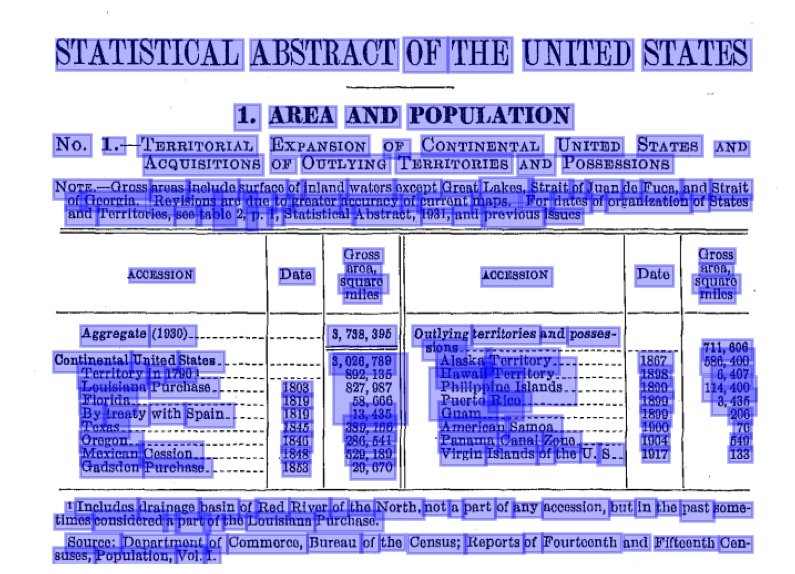

In [2]:
from doctr.utils import visualization as dtviz

pagefig = dtviz.visualize_page(result.pages[0].export(), pdf_doc[0])

ax = pagefig.get_axes()
ax[0].set_ylim([700, 200])
ax[0].set_xlim([250, 950])
extent = ax[0].get_window_extent().transformed(pagefig.dpi_scale_trans.inverted())
#pagefig.savefig("/Users/christianmoscardi/cmoscardi.github.io/static/images/stat_abstracts/doctr_naive_result.png",
#                bbox_inches=extent)

## 2. Crop images

In [3]:
import fitz
from PIL import Image
import cv2
import numpy as np

def points_to_inches(points):
    return points / 72.0

def load_images_from_pdf(pdf_path, start_page=None, n_pages=None):
    imgs = []
    with fitz.open(pdf_path) as pdf:
        sp =  start_page if start_page is not None else 0
        for i in range(len(pdf)):
            if i < sp:
                continue
            if n_pages is not None and (i - sp) >= n_pages:
                break
                
            page = pdf[i]
            mat = fitz.Matrix(1, 1)
            pm = page.get_pixmap(matrix=mat, alpha=False)
            # if width or height > 2000 pixels, don't enlarge the image
            if pm.width <= 2000 and pm.height <= 2000:
                pm = page.get_pixmap(matrix=fitz.Matrix(3, 3), alpha=False)    
            img = Image.frombytes("RGB", [pm.width, pm.height], pm.samples)
            img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            imgs.append(Image.fromarray(img))
    
    return imgs


In [4]:
images = load_images_from_pdf("stat_abstracts_explore_doctr/1940-02-first-ten.pdf")

### The laziest cropping algorithm

In [5]:
def crop_image(img):
    """
    A very low-budget cropping algorithm assuming a white background
    """
    imarr = np.array(img).copy()
    # this 199 threshold was determined "empirically"
    yindex, xindex, zindex = np.where(imarr < 199)
    xmin, xmax, ymin, ymax = xindex.min(), xindex.max(), yindex.min(), yindex.max()
    cropped_imarr = imarr[ymin:ymax, xmin:xmax, :]
    cropped_image = Image.fromarray(cropped_imarr)
    return cropped_image, (xmin, ymin)


In [6]:
cropped_images, offsets = zip(*[crop_image(image) for image in images])

[]

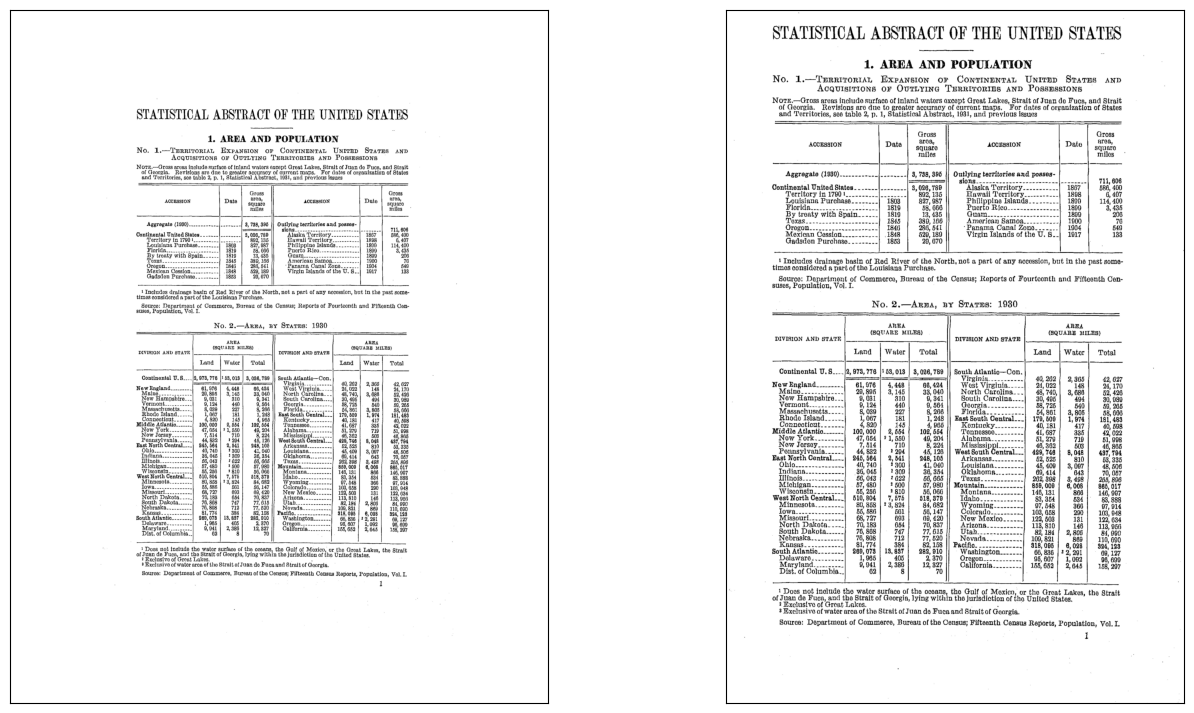

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.imshow(images[0])
ax2.imshow(cropped_images[0])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

# fig.savefig("/Users/christianmoscardi/cmoscardi.github.io/static/images/stat_abstracts/cropping_algo_results.png", 
#             transparent=True)

In [8]:
result = model([np.array(cropped_images[0])])

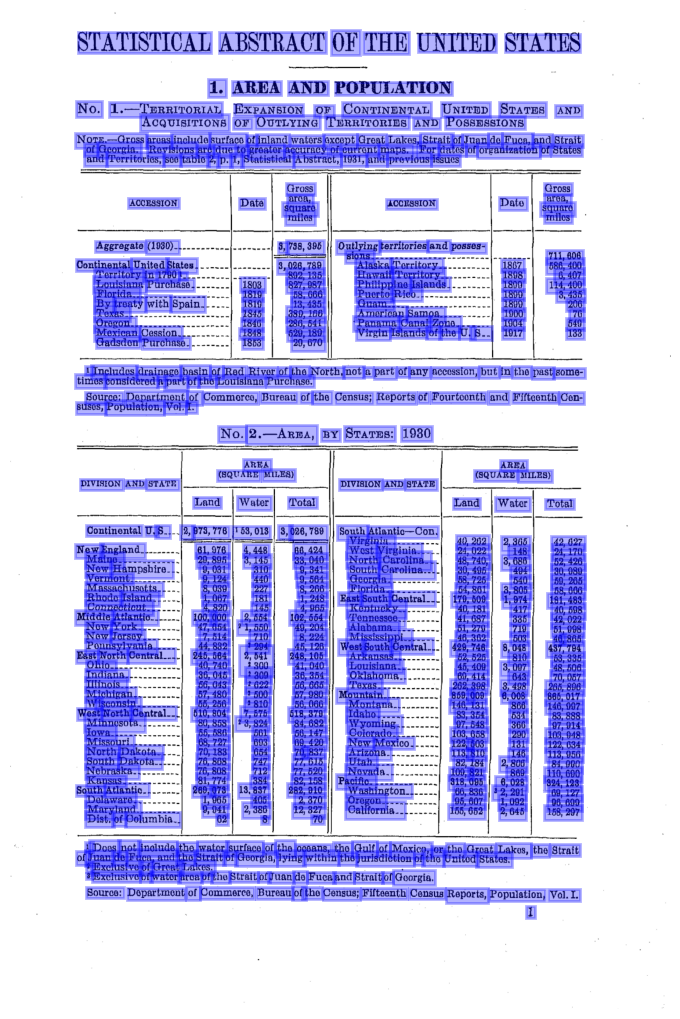

In [9]:
result.show()

## 3. Fine-tune

Step 1: put the page images in label studio and add bboxes.

### Do detection

In [10]:
import json
import hashlib
import os

def create_cropped_detection_results(cropped_images, 
                                     cropped_image_offsets,
                                     detection_results_doctr):
    cropped_results_doctr = {}

    cropped_image_paths = [f"stat_abstracts_explore_doctr/detection/images/1940-02.pdf-pg-{i}-cropped.png"\
                           for i in range(len(cropped_images))]
    cropped_image_fnames = [os.path.basename(path) for path in cropped_image_paths]
    
    image_fname_crosswalk = {path: path.replace("-cropped", "")
                             for path in cropped_image_fnames}

    cropped_results_doctr = {}
    for i, image in enumerate(cropped_images):
        cropped_image_path = cropped_image_paths[i]
        image.save(cropped_image_path)
        
        with open(cropped_image_path, 'rb') as cropped_image_f:
            cropped_img_hash = hashlib.sha256(cropped_image_f.read()).hexdigest()

        orig_image_fname = image_fname_crosswalk[cropped_image_fnames[i]]

        if orig_image_fname not in detection_results_doctr:
            print(f"skipping {orig_image_fname} for cropped detection results")
            continue
            
        bboxes = detection_results_doctr[orig_image_fname]["polygons"]
        xoffset, yoffset = cropped_image_offsets[i]
        bboxes_arr = np.array(bboxes)
        bboxes_arr[:,:,0] = bboxes_arr[:,:,0] - xoffset
        bboxes_arr[:,:,1] = bboxes_arr[:,:,1] - yoffset

        cropped_image_info = {"img_hash": cropped_img_hash,
                              "img_dimensions": (image.height, image.width),
                              "polygons": bboxes_arr.tolist()}
        cropped_results_doctr[cropped_image_fnames[i]] = cropped_image_info
        
    return cropped_results_doctr 
    

def load_and_convert_labelstudio_detection_results(labelstudio_results_path,
                                                   images,
                                                   cropped_images,
                                                   cropped_image_offsets,
                                                   include_regular_results=True,
                                                   include_cropped_results=True):
    """
    include_regular_results: saves regular images and creates bboxes for cropped images
    include_cropped_results: saves cropped images and creates bboxes for cropped images
    """

    # 1. save off images
    image_paths = [f"stat_abstracts_explore_doctr/detection/images/1940-02.pdf-pg-{i}.png" for i in range(len(images))]
    [image.save(image_paths[i]) for i, image in enumerate(images)]

    
    with open(labelstudio_results_path) as detection_results_labelstudio_f:
        detection_results_labelstudio = json.load(detection_results_labelstudio_f)
        
    detection_results_doctr = {}
    img_fnames_only = [x.split("/")[-1] for x in image_paths]
    for result in detection_results_labelstudio:
        fname = result['data']['ocr'].split("/")[-1]

            
        detection_results_doctr[fname] = {}
        image_ix = img_fnames_only.index(fname)
        img = images[image_ix]
        h, w = img.height, img.width
    
        detection_results_doctr[fname]['img_dimensions'] = (h, w)
        
        with open(image_paths[image_ix], 'rb') as image_f:
            img_hash = hashlib.sha256(image_f.read()).hexdigest()
        detection_results_doctr[fname]['img_hash'] = img_hash
    
        detection_results_doctr[fname]['polygons'] = []
        for annotation in result["annotations"][0]['result']:
            if annotation['type'] != 'rectangle':
                continue
            val = annotation['value']
            x0 = (val['x'] / 100) * w
            y0 = (val['y'] / 100) * h
            x1 = ((val['x'] + val['width']) / 100) * w
            y1 = ((val['y'] + val['height']) / 100) * h
            polygon = [[x0, y0], [x1, y0], [x1, y1], [x0, y1]]
            detection_results_doctr[fname]['polygons'].append(polygon)

    final_results = {}
    if include_cropped_results:
        cropped_results_doctr = create_cropped_detection_results(cropped_images, 
                                                                 cropped_image_offsets, 
                                                                 detection_results_doctr)
        final_results = final_results | cropped_results_doctr
        
    if include_regular_results:
        final_results = final_results | detection_results_doctr
        
    return final_results


In [11]:
import shutil
from sklearn.model_selection import train_test_split

def create_detection_finetune_dirstructure(base_path):
    """
    DocTR expects this file structure for its finetuning
    """
    train_path = os.path.join(base_path, "train")
    val_path = os.path.join(base_path, "val")
    images_path = os.path.abspath(os.path.join(base_path, "images"))
    print(images_path)

    if os.path.exists(train_path):
        shutil.rmtree(train_path)
    if os.path.exists(val_path):
        shutil.rmtree(val_path)
    if os.path.exists(images_path):
        shutil.rmtree(images_path)

    if not os.path.exists(images_path):
        os.mkdir(images_path)
        
    if not os.path.exists(train_path):
        os.mkdir(train_path)
        os.symlink(images_path, os.path.join(train_path, "images"))
    
    if not os.path.exists(val_path):
        os.mkdir(val_path)
        os.symlink(images_path, os.path.join(val_path, "images"))


def create_detection_train_val_set(base_path, detection_results_doctr):
    """
    DocTR expects this file structure for its finetuning
    """
    train_path = os.path.join(base_path, "train")
    val_path = os.path.join(base_path, "val")
    images_path = os.path.abspath(os.path.join(base_path, "images"))
    
    print(f"{len(list(detection_results_doctr.keys()))} results from labelling")

    # after running the fine-tuning the first time, hardcoded this
    # but pg3 was a random selection at first!
    # train, val = train_test_split(list(detection_results_doctr.keys()), 
    #                               train_size=.9)
    page_names = list(detection_results_doctr.keys())
    train = [x for x in page_names if 'pg-3' not in x]
    val = [x for x in page_names if 'pg-3' in x]

    print(f"{len(train)} training items")
    print(f"{len(val)} validation items: {val}")
    
    train_dict = {k: detection_results_doctr[k] for k in train}
    val_dict = {k: detection_results_doctr[k] for k in val}
    with open(os.path.join(train_path, "labels.json"), "w+") as detection_results_doctr_f:
        json.dump(train_dict, detection_results_doctr_f)
    
    with open(os.path.join(val_path, "labels.json"), "w+") as detection_results_doctr_f:
        json.dump(val_dict, detection_results_doctr_f)

    return train_path, val_path

In [12]:
json_results_path = "stat_abstracts_explore_doctr/detection/results_labelstudio.json"

In [13]:
# need the full doctr package, not included with pip install
# !git clone https://github.com/mindee/doctr.git doctr_package

In [14]:
import subprocess

def finetune_detection(doctr_base, train_path, val_path, model_output_path, n_epochs=10):
    SCRIPT_PATH =  "references/detection/train_tensorflow.py"
    ARGS = ["--train_path", train_path, 
            "--val_path", val_path, 
            "db_resnet50", 
            "--pretrained",
            "--lr", ".002",
            "--epochs", str(n_epochs),
            "--batch_size", str(2),
            "--name", model_output_path]
    
    command = ["python", os.path.join(doctr_base, SCRIPT_PATH), *ARGS]
    
    subprocess.call(command)

#### Train just on the cropped images

Experimented with including uncropped but fine-tuning just on cropped seemed best

Validation page from full run: page3

In [15]:
create_detection_finetune_dirstructure("stat_abstracts_explore_doctr/detection")

finetune_tasks_for_doctr = load_and_convert_labelstudio_detection_results(
    json_results_path,
    images,
    cropped_images,
    offsets,
    include_cropped_results=True,
    include_regular_results=False)

train_path, val_path = create_detection_train_val_set("stat_abstracts_explore_doctr/detection", 
                                                      finetune_tasks_for_doctr)
# finetune_detection("doctr_package", 
#                    train_path, 
#                    val_path, 
#                    "stat_abstracts_explore_doctr/detection/finetuned_detection_cropped_only/", 
#                    n_epochs=200)


/Users/christianmoscardi/ocr/ocr-omnibus/stat_abstracts_blog/stat_abstracts_explore_doctr/detection/images
skipping 1940-02.pdf-pg-6.png for cropped detection results
9 results from labelling
8 training items
1 validation items: ['1940-02.pdf-pg-3-cropped.png']


#### View finetuned model results

In [16]:
from doctr.models import ocr_predictor, recognition_predictor, detection_predictor
from doctr.models import ocr_predictor, db_resnet50, crnn_vgg16_bn
from importlib import reload
import doctr.models
reload(doctr.models)


def create_doctr_model(det_weights_path=None, reco_weights_path=None):


    det_model = doctr.models.db_resnet50(pretrained=True)
    reco_model = doctr.models.crnn_vgg16_bn(pretrained=True)
    
    if det_weights_path is not None:
        det_model.load_weights(det_weights_path)

    if reco_weights_path is not None:
        reco_model.load_weights(reco_weights_path)
        
    full_predictor = doctr.models.ocr_predictor(det_arch=det_model, 
                                           reco_arch=reco_model,
                                           pretrained=True)
    
    det_predictor = detection_predictor(arch=det_model, 
                                        pretrained=True)

    # baseline performs optimally with default
    # for some reason (and i found this by pure luck)
    # the finetuned model works much better when instantiated this way
    # the ocr_predictor must have some extra default config setting
    # that hinders the finetuned model (i think something in the preprocessing)
    if det_weights_path is not None:
        full_predictor.det_predictor = det_predictor
        
    # this seems to help tighten up boxes a bit
    full_predictor.det_predictor.model.postprocessor.unclip_ratio = 1.2
    det_predictor.model.postprocessor.unclip_ratio = 1.2


    return det_predictor, full_predictor
    
baseline_det_predictor, baseline_ocr_predictor  = create_doctr_model(None)
finetuned_det_predictor, finetuned_ocr_predictor_det_only = create_doctr_model("stat_abstracts_explore_doctr/detection/finetuned_detection_cropped_only/weights")

#### Evaluate finetuned detection results

In [17]:
from doctr.datasets import DetectionDataset


json_results_path = "stat_abstracts_explore_doctr/results_labelstudio.json"
cropped_images, offsets = zip(*[crop_image(image) for image in images])

train_cropped = DetectionDataset(train_path + "/images", train_path + "/labels.json")
val_cropped = DetectionDataset(val_path + "/images", val_path + "/labels.json")

In [18]:
cropped_images_for_eval, targets = list(zip(*train_cropped))
cropped_val_images_for_eval, val_targets = list(zip(*val_cropped))
val_fnames = [x[0] for x in val_cropped.data]
train_fnames = [x[0] for x in train_cropped.data]

In [19]:
train_finetune_preds = [finetuned_ocr_predictor_det_only.det_predictor([x])[0]['words'] for x in cropped_images_for_eval]
train_baseline_preds = [baseline_ocr_predictor.det_predictor([x])[0]['words'] for x in cropped_images_for_eval]

val_finetune_preds = [finetuned_ocr_predictor_det_only.det_predictor([x])[0]['words'] for x in cropped_val_images_for_eval]
val_baseline_preds = [baseline_ocr_predictor.det_predictor([x])[0]['words'] for x in cropped_val_images_for_eval]


In [20]:
from doctr.utils.metrics import LocalizationConfusion
lc_baseline_train = LocalizationConfusion(iou_thresh=.5)
lc_baseline_val = LocalizationConfusion(iou_thresh=.5)
lc_finetune_train = LocalizationConfusion(iou_thresh=.5)
lc_finetune_val = LocalizationConfusion(iou_thresh=.5)

print("format: recall, precision, mean_iou")
print("TRAIN")
for i, fname in enumerate(train_fnames):
    print("========")
    print(fname)
    lc_baseline_for_file = LocalizationConfusion(iou_thresh=.5)
    lc_finetune_for_file = LocalizationConfusion(iou_thresh=.5)

    target = targets[i]
    baseline_pred = train_baseline_preds[i]
    finetune_pred = train_finetune_preds[i]
    
    lc_baseline_for_file.update(target['words'], baseline_pred[:, :4])
    lc_finetune_for_file.update(target['words'], finetune_pred[:, :4])
    print("baseline:", lc_baseline_for_file.summary())
    print("finetune:", lc_finetune_for_file.summary())
    lc_baseline_train.update(target['words'], baseline_pred[:, :4])
    lc_finetune_train.update(target['words'], finetune_pred[:, :4])

print("\nVAL")
for i, fname in enumerate(val_fnames):
    print("========")
    print(fname)
    lc_baseline_for_file = LocalizationConfusion(iou_thresh=.5)
    lc_finetune_for_file = LocalizationConfusion(iou_thresh=.5)

    target = val_targets[i]
    baseline_pred = val_baseline_preds[i]
    finetune_pred = val_finetune_preds[i]
    
    lc_baseline_for_file.update(target['words'], baseline_pred[:, :4])
    lc_finetune_for_file.update(target['words'], finetune_pred[:, :4])
    print("baseline:", lc_baseline_for_file.summary())
    print("finetune:", lc_finetune_for_file.summary())
    lc_baseline_val.update(target['words'], baseline_pred[:, :4])
    lc_finetune_val.update(target['words'], finetune_pred[:, :4])


print("\noverall baseline (train):", lc_baseline_train.summary())
print("overall finetune (train):", lc_finetune_train.summary())
print("overall baseline (val):", lc_baseline_val.summary())
print("overall finetune (val):", lc_finetune_val.summary())

format: recall, precision, mean_iou
TRAIN
1940-02.pdf-pg-0-cropped.png
baseline: (0.9383561643835616, 0.9464594127806563, 0.7)
finetune: (0.964041095890411, 0.9673539518900344, 0.73)
1940-02.pdf-pg-1-cropped.png
baseline: (0.9460708782742681, 0.8989751098096632, 0.71)
finetune: (0.9537750385208013, 0.958204334365325, 0.74)
1940-02.pdf-pg-2-cropped.png
baseline: (0.9154302670623146, 0.8864942528735632, 0.67)
finetune: (0.9762611275964391, 0.9619883040935673, 0.74)
1940-02.pdf-pg-4-cropped.png
baseline: (0.6759036144578313, 0.4609695973705834, 0.48)
finetune: (0.9602409638554217, 0.9672330097087378, 0.73)
1940-02.pdf-pg-5-cropped.png
baseline: (0.9573241061130334, 0.8636836628511967, 0.67)
finetune: (0.9838523644752019, 0.9849884526558892, 0.74)
1940-02.pdf-pg-7-cropped.png
baseline: (0.845442536327609, 0.6130268199233716, 0.55)
finetune: (0.9841479524438573, 0.9802631578947368, 0.75)
1940-02.pdf-pg-8-cropped.png
baseline: (0.9017094017094017, 0.7834158415841584, 0.61)
finetune: (0.99715

#### Visually compare results on out-of-sample page
I didn't label this one out of laziness

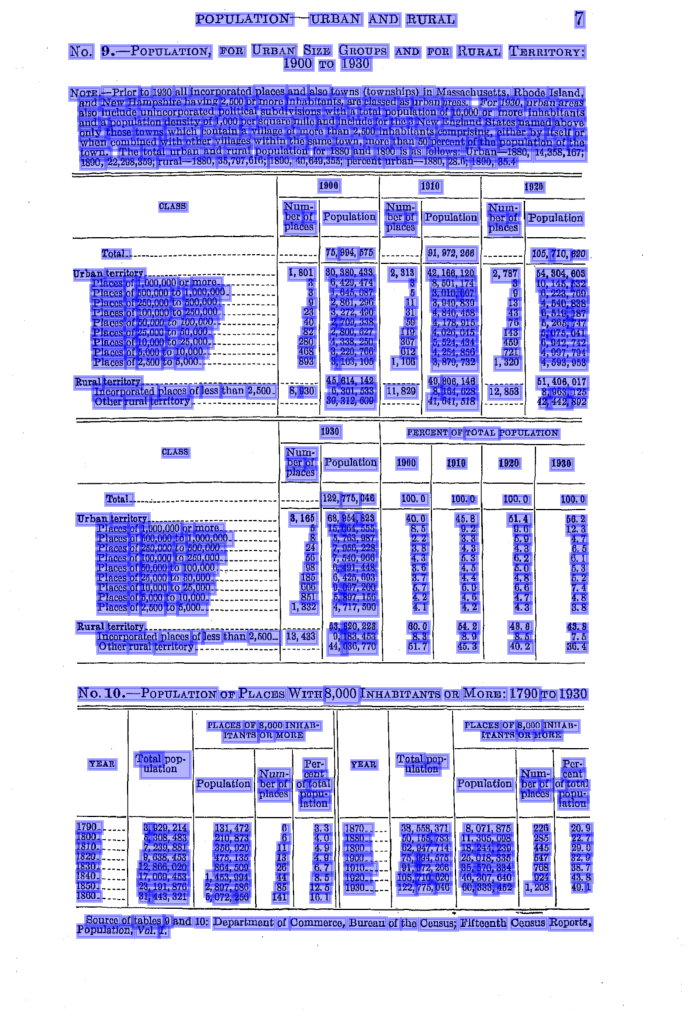

In [21]:
baseline_ocr_predictor([np.array(cropped_images[6])]).show()

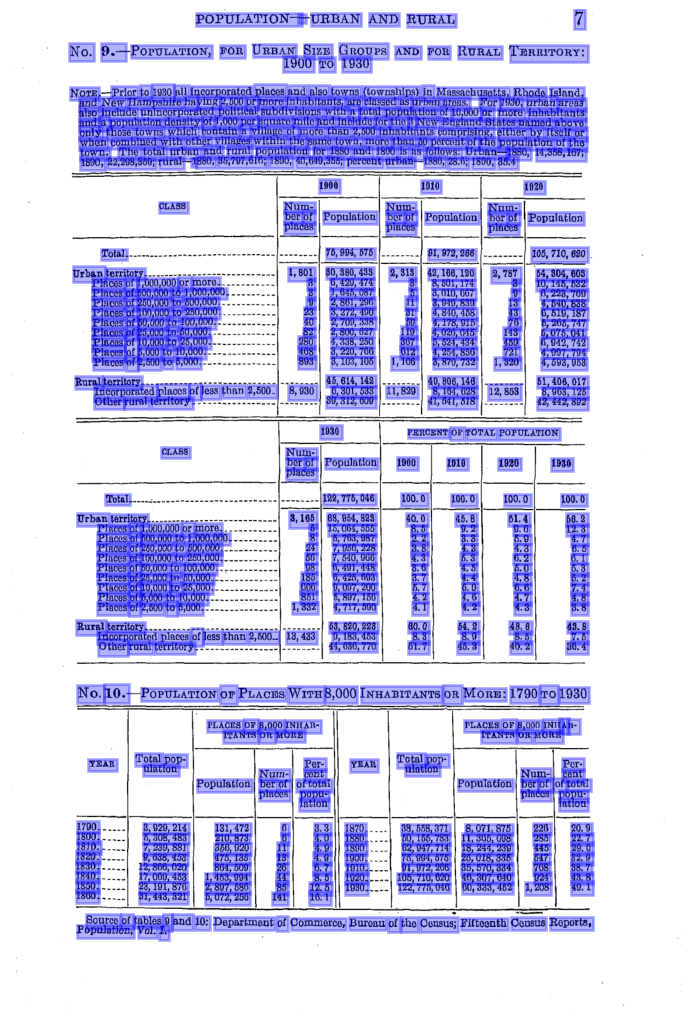

In [22]:
finetuned_ocr_predictor_det_only([np.array(cropped_images[6])]).show()

Nice.

### Do recognition

In [23]:
import random
def gen_reco_tasks_for_labelstudio(detection_results_doctr,
                                     images_path,
                                     ocr_reco_images_path,
                                     ocr_reco_annotations_path,
                                     reco_predictor=None,
                                     page_number=None):
    """
    Using the ground truth detection results, generate recognition labelling dataset

    images_path: path to page images
    reco_images_path: path where reco images should be saved
    ocr_reco_annotations_path: path where annotations should be saved
    page_number: 
    """

    # 1. extract info from doctr ground truth dict (easy to work with)
    # include a prebaked prediction from baseline model
    if reco_predictor:
        rec_model = reco_predictor
    else:
        rec_model = recognition_predictor(pretrained=True)

    all_image_info = []
    all_ocr_results = []
    for (i, (k, v)) in enumerate(detection_results_doctr.items()):
        if page_number and f'pg-{page_number}' not in k:
            continue
        image_path = os.path.join(images_path, k)
        imarr = np.array(Image.open(image_path))
        slices = []
        for j, polygon in enumerate(v["polygons"]):
            x1, y1 = [max(int(x), 0) for x in polygon[0]]
            x2, y2 = [max(int(x), 0) for x in polygon[-2]]
            imslice = imarr[y1:y2, x1:x2, :]
            fname = "{}-im{}.jpg".format(os.path.basename(k), j)
            slices.append((imslice, fname, [x1, y1, x2, y2]))
            im_path = os.path.join(ocr_reco_images_path, fname)
            Image.fromarray(imslice).save(im_path)
            
        results = rec_model([s[0] for s in slices])
        all_image_info += slices
        all_ocr_results += results

    # 2. reformat into labelstudio format 
    outs = []
    for (imslice, fname, xy), (text, confidence) in zip(all_image_info, all_ocr_results):
        
        out_json = {}
        out_json["data"] = {}
        # serve images via SimpleHTTPServer
        out_json["data"]["captioning"] = "http://localhost:8001/{}".format(fname)
        out_json["predictions"] = [
            {"model_version": "doctr_latest_08172024",
             "score": confidence,
             "xy": xy,
             "result": [{"type": "textarea",
                         "from_name": "caption",
                         "to_name": "image",
                         "value": {
                            "text": [text]
                         }
                        }
                       ]
            }
        ]
        outs.append(out_json)
    return outs


def sample_and_write_reco_tasks(outs):
    # 3. sample by confidence band and write off
    strata_by_size = {}
    for stratum in range(0, 10, 1):
        min_conf = stratum / 10
        max_conf = min_conf + .1
        filt = [x for x in outs if x['predictions'][0]['score'] > min_conf\
                                and x['predictions'][0]['score'] <= max_conf]
        if len(filt) > 50:
            stratified_data = random.sample(filt, 50)
        else:
            print("small sample, {}".format(len(filt)))
            stratified_data = filt
        strata_by_size[stratum] = stratified_data


    reco_tasks_path = os.path.join(ocr_reco_annotations_path, "tasks.json")
    reco_tasks = list(sum(strata_by_size.values(), []))
    with open(reco_tasks_path, "w+") as reco_tasks_f:
        json.dump(reco_tasks, reco_tasks_f)

In [24]:
json_results_path = "stat_abstracts_explore_doctr/detection/results_labelstudio.json"
with open(json_results_path) as detection_results_labelstudio_f:
    detection_results_labelstudio = json.load(detection_results_labelstudio_f)


detection_results_doctr = load_and_convert_labelstudio_detection_results(
    json_results_path,
    images,
    cropped_images,
    offsets,
    include_cropped_results=True,
    include_regular_results=False)

skipping 1940-02.pdf-pg-6.png for cropped detection results


In [25]:
ocr_reco_annotations_path = "stat_abstracts_explore_doctr/recognition"
ocr_reco_images_path = ocr_reco_annotations_path + "/images"
if not os.path.exists(ocr_reco_annotations_path): 
    os.mkdir(ocr_reco_annotations_path)
    os.mkdir(ocr_reco_images_path)

# where the page images live
images_path = "stat_abstracts_explore_doctr/detection/images"

In [26]:
# reco_tasks_for_labelstudio = gen_reco_tasks_for_labelstudio(detection_results_doctr,
#                                                             images_path,
#                                                             ocr_reco_images_path,
#                                                             ocr_reco_annotations_path)

# sample_and_write_reco_tasks(reco_tasks_for_labelstudio)

#### Now label in labelstudio and load back...

In [27]:
# from http.server import HTTPServer, SimpleHTTPRequestHandler, test
# import sys

# class CORSRequestHandler (SimpleHTTPRequestHandler):
#     def end_headers (self):
#         self.send_header('Access-Control-Allow-Origin', '*')
#         SimpleHTTPRequestHandler.end_headers(self)


# def main(port):
#     test(CORSRequestHandler, HTTPServer, port=port)

# prev_cwd = os.getcwd()
# print(prev_cwd)
# os.chdir("stat_abstracts_explore_doctr/recognition/images/")
# main(8001)
# os.chdir(prev_cwd)

In [28]:
import pandas as pd

def load_convert_reco_results_from_labelstudio(ocr_reco_results_path):
    with open(ocr_reco_results_path) as reco_results_f:
        reco_results_labelstudio = json.load(reco_results_f)
    
    reco_results_labelstudio = [x for x in reco_results_labelstudio\
                                if not x['annotations'][0]['was_cancelled']]
    
    reco_results_doctr = {}
    for result in reco_results_labelstudio:
        text = result['annotations'][0]['result'][0]['value']['text'][0]
        text = text.replace("\n", "")
        text = text.replace(r" ", "")
        image = result['data']['captioning'].split("/")[-1]
        reco_results_doctr[image] = text
        
    return reco_results_labelstudio, reco_results_doctr


def create_reco_finetune_dirstructure(ocr_reco_annotations_path,
                                      ocr_reco_images_path,
                                      reco_results_doctr):

    train_path = os.path.abspath(os.path.join(ocr_reco_annotations_path, "train"))
    val_path = os.path.abspath(os.path.join(ocr_reco_annotations_path, "val"))

    if os.path.exists(train_path):
        shutil.rmtree(train_path)
        
    if os.path.exists(val_path):
        shutil.rmtree(val_path)

    if not os.path.exists(train_path):
        os.mkdir(train_path)
        os.symlink(os.path.abspath(ocr_reco_images_path), 
                   os.path.abspath(os.path.join(train_path, "images")))
    
    if not os.path.exists(val_path):
        os.mkdir(val_path)
        blah = (os.path.abspath(os.path.join(val_path, "images")))
        print(blah)
        os.symlink(os.path.abspath(ocr_reco_images_path), blah)
    
    print(f"{len(list(reco_results_doctr.keys()))} results from labelling")
    train, val = train_test_split(list(reco_results_doctr.keys()), 
                                  train_size=.9)
    print(f"{len(train)} training items")
    print(f"{len(val)} validation items")
    
    train_dict = {k: reco_results_doctr[k] for k in train}
    val_dict = {k: reco_results_doctr[k] for k in val}
    with open(os.path.join(train_path, "labels.json"), "w+") as reco_results_doctr_f:
        json.dump(train_dict, reco_results_doctr_f)
    
    with open(os.path.join(val_path, "labels.json"), "w+") as reco_results_doctr_f:
        json.dump(val_dict, reco_results_doctr_f)

    return train_path, val_path

def finetune_reco(train_path, val_path, name):
    DOCTR_BASE = "doctr_package"
    SCRIPT_PATH =  "references/recognition/train_tensorflow.py"
    ARGS = ["--train_path", train_path, 
            "--val_path", val_path, 
            "crnn_vgg16_bn", 
            "--pretrained",
            "--lr", ".001",
            "--epochs", "10",
            "--name", name,
            "--vocab", "legacy_french"]#dont ask
    
    command = ["python", os.path.join(DOCTR_BASE, SCRIPT_PATH), *ARGS]
    
    subprocess.call(command)

def eval_reco_results_from_labelstudio(reco_results_labelstudio):
    preds = []
    actuals = []
    confidences = []
    fnames = []
    for result in reco_results_labelstudio:
        if result['annotations'][0]['was_cancelled']:
            continue
        actual = result['annotations'][0]['result'][0]['value']['text'][0]
        pred = result['annotations'][0]['prediction']['result'][0]['value']['text'][0]
        url = result['data']['captioning']
        fname = url.split("/")[-1]
        confidence = result['annotations'][0]['prediction']['score']
        preds.append(pred)
        actuals.append(actual)
        confidences.append(confidence)
        fnames.append(fname)
    
    
    df = pd.DataFrame({"pred": preds, 
                       "actual": actuals, 
                       "confidence": confidences, 
                       "fname": fnames})
    df['correct'] = df['pred'] == df['actual']
    df["base_confidence"] = (df["confidence"] * 10).astype(int)
    return df

In [29]:
reco_results_labelstudio_path = "stat_abstracts_explore_doctr/recognition/results_labelstudio.json"
reco_results_labelstudio, reco_results_doctr = load_convert_reco_results_from_labelstudio(reco_results_labelstudio_path)

In [30]:
# this was specifically low-confidence predictions, overall recognition looks better
# on a representative set of words
orig_accuracy = eval_reco_results_from_labelstudio(reco_results_labelstudio).correct.mean()
print("original OCR accuracy: ", orig_accuracy)

original OCR accuracy:  0.673972602739726


In [31]:
reco_train_path, reco_val_path = create_reco_finetune_dirstructure(ocr_reco_annotations_path,
                                                         ocr_reco_images_path,
                                                         reco_results_doctr)

# finetune_reco(os.path.abspath(reco_train_path), os.path.abspath(reco_val_path), 
#               "stat_abstracts_explore_doctr/recognition/reco_finetuned")

/Users/christianmoscardi/ocr/ocr-omnibus/stat_abstracts_blog/stat_abstracts_explore_doctr/recognition/val/images
365 results from labelling
328 training items
37 validation items


#### Evaluate recognition

Note: I killed the original validation set by re-running this notebook and failing to initially set a random seed... and can't think of a way to recover it. Oh well. Numbers in the blog post are correct for actual held-out validation set.

In [32]:
from doctr.datasets import RecognitionDataset

reco_train = RecognitionDataset(ocr_reco_images_path, "stat_abstracts_explore_doctr/recognition/train/labels.json")
reco_val = RecognitionDataset(ocr_reco_images_path, "stat_abstracts_explore_doctr/recognition/val/labels.json")

reco_images, targets = list(zip(*reco_train))

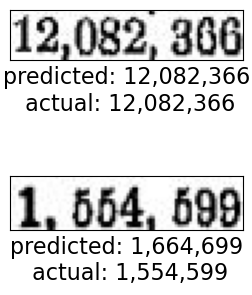

In [33]:
reco_train_preds = baseline_ocr_predictor.reco_predictor(list(reco_images))

fig, axes = plt.subplots(2, 1, figsize=(3, 4))
axes = axes.flatten()
axes_used = 0
for i, ( image, pred, target)  in enumerate(zip(reco_images, reco_train_preds, targets)):
    p, c = pred
    if axes_used == len(axes):
        break

    # want to show some larger, bad numbers
    if c >= .4 or p =='17.2' or 'FOFULATION' in p or len(p) < 6 or p=='3,738,395' or '7,400' in p:
        continue

    ax = axes[axes_used]
    axes_used = axes_used + 1
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    ax.set_xlabel(f"predicted: {pred[0]}\n actual: {target}", color='black', fontsize=16)


# fig.savefig("/Users/christianmoscardi/cmoscardi.github.io/static/images/stat_abstracts/bad_number_examples.png",
#             transparent=True)

In [34]:
_, finetuned_reco_predictor = create_doctr_model(reco_weights_path="stat_abstracts_explore_doctr/recognition/reco_finetuned/weights")
_, original_reco_predictor = create_doctr_model()

Because I borked the validation set, the below does not reproduce the recognition metrics the blog post, but may be of interest if you are trying to re-run this. Basically, this validation set includes records we trained on. And at like 99% accurate on out-of-sample data, it just gets everything it's ever seen correct.

In [35]:
with open(os.path.join(reco_val_path, "labels.json")) as val_labels_f:
    val_labels = json.load(val_labels_f)


val_labels_zipped = list(val_labels.items())
val_ocr_images = [Image.open(os.path.join(ocr_reco_images_path, fname)) for fname, _ in val_labels_zipped]

val_ocr_results = finetuned_reco_predictor.reco_predictor([np.array(x) for x in val_ocr_images])
val_orig_results = original_reco_predictor.reco_predictor([np.array(x) for x in val_ocr_images])

In [36]:
val_results_df = pd.DataFrame(val_ocr_results, columns=['pred', 'confidence'])
val_results_df['actual'] = [actual for _, actual in val_labels_zipped]
val_results_df['path'] = [path for path, _ in val_labels_zipped]
val_results_df['orig_pred'] = [pred for pred, confidence in val_orig_results]
val_results_df['orig_confidence'] = [confidence for pred, confidence in val_orig_results]

In [37]:
val_results_df['correct'] = (val_results_df['pred'] == val_results_df['actual'])
val_results_df['orig_correct'] = (val_results_df['orig_pred'] == val_results_df['actual'])

In [38]:
val_results_df['correct'].mean(), val_results_df['orig_correct'].mean(), len(val_results_df)

(0.972972972972973, 0.5675675675675675, 37)

In [39]:
val_results_df['orig_correct'].mean()

0.5675675675675675

In [40]:
val_results_df["confidence_band"] = (val_results_df["confidence"] * 10).astype(int)

In [41]:
val_results_df.groupby("confidence_band").correct.agg(["mean", "count"])

mean  count
confidence_band             
4                 0.0      1
6                 1.0      1
7                 1.0      4
8                 1.0      7
9                 1.0     24

In [42]:
val_results_df[~val_results_df.correct]

pred  confidence actual                                    path orig_pred  \
27  16:2     0.43789   16.2  1940-02.pdf-pg-8-cropped.png-im249.jpg      16,2   

    orig_confidence  correct  orig_correct  confidence_band  
27         0.288032    False         False                4

In [43]:
val_results_df['image'] = val_results_df['path'].apply(lambda x: Image.open(os.path.join(ocr_reco_images_path, x)))

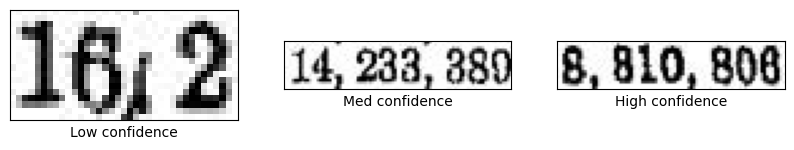

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2))

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

ax1.set_xlabel("Low confidence", color='black')
ax2.set_xlabel("Med confidence", color='black')
ax3.set_xlabel("High confidence", color='black')

ax1.imshow(val_results_df[val_results_df.confidence_band == 4].iloc[0].image)
ax2.imshow(val_results_df[val_results_df.confidence_band == 7].iloc[0].image)
ax3.imshow(val_results_df[val_results_df.confidence_band == 9].iloc[0].image)

fig.savefig("/Users/christianmoscardi/cmoscardi.github.io/static/images/stat_abstracts/example_ocr_images.png", 
            transparent=True)

## End to end

### Vibe check / Look at results visually

In [46]:
finetuned_det_predictor, full_finetuned_predictor = create_doctr_model(reco_weights_path="stat_abstracts_explore_doctr/recognition/reco_finetuned/weights",
                                                 det_weights_path="stat_abstracts_explore_doctr/detection/finetuned_detection_cropped_only/weights")


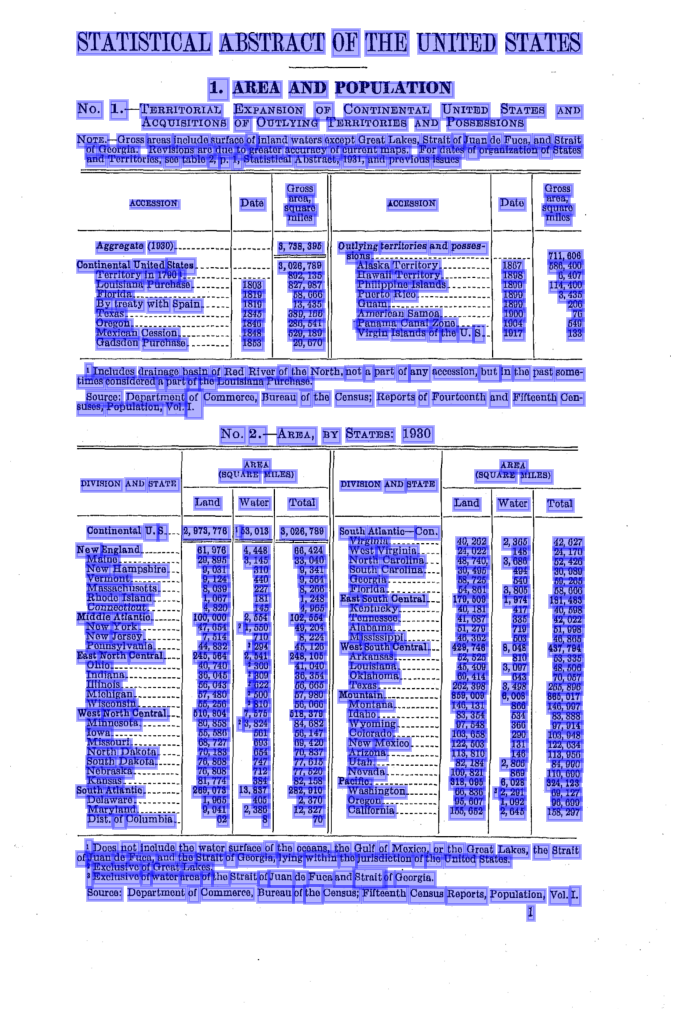

In [47]:
full_finetuned_predictor([np.array(cropped_images[0])]).show()

In [48]:
# there must be a rendering bug with ACQUISITIONS OF OUTLYING TERRITORIES... 
print(full_finetuned_predictor([np.array(cropped_images[0])]).render()[:500])

STATISTICAL ABSTRACT OF THE UNITED STATES

1. AREA AND POPULATION

No. 1. TERRITORIAL EXPANSION OF CONTINENTAL UNITED STATES AND
NOTE. Gross areas include surface of inland waters Gxcept Great Lakes, Strait of Juan de Fuca, and Strait
of Georgia. Revisions arc due to greater accuracy of current maps. For dates of organization of States

ACQUISITIONS OF OUTLYING TERRITORIES AND POSSESSIONS

and Territories, see table 2, p. 1, Statistical Abstract, 1931, and previous issues

Gross
arca,
square
mil


### one final round of labelling -- validation page
in-sample and out-of-sample error rates are the same tbh but in the absence of any other criteria, use validation page

In [49]:
val_page_reco_tasks = gen_reco_tasks_for_labelstudio(detection_results_doctr,
                                                   images_path, 
                                                   ocr_reco_images_path,
                                                   ocr_reco_annotations_path,
                                                   reco_predictor=full_finetuned_predictor.reco_predictor,
                                                   page_number=3)


val_page_reco_tasks_path = os.path.join(ocr_reco_annotations_path, "tasks_for_e2e_validation_pg3.json")
with open(val_page_reco_tasks_path, "w+") as reco_tasks_f:
    json.dump(val_page_reco_tasks, reco_tasks_f)

In [50]:
# have fun, future me
(pd.Series(x['predictions'][0]['score'] for x in val_page_reco_tasks) <= .95).sum()

122

In [51]:
ocr_val_reco_results_path = "stat_abstracts_explore_doctr/recognition/results_labelstudio_incl_val_page.json"
reco_val_results_labelstudio, reco_val_results_doctr = load_convert_reco_results_from_labelstudio(ocr_val_reco_results_path)

gt_reco_for_val_page = []
for (i, (k, v)) in enumerate(detection_results_doctr.items()):
    if 'pg-3' not in k:
        continue
    for j, polygon in enumerate(v["polygons"]):
        fname = "{}-im{}.jpg".format(os.path.basename(k), j)
        gt_reco_for_val_page.append(reco_val_results_doctr.get(fname, ''))

gt_reco_for_val_page = np.array(gt_reco_for_val_page)
gt_detection_for_val_page = np.array(detection_results_doctr['1940-02.pdf-pg-3-cropped.png']['polygons'])
gt_detection_for_val_page = gt_detection_for_val_page[:, [0, 2], :].reshape(-1, 4)

gt_detection_for_val_page.shape, gt_reco_for_val_page.shape

((539, 4), (539,))

In [52]:
val_baseline_det_result = baseline_ocr_predictor.det_predictor([np.array(cropped_images[3])])
val_finetune_det_result = full_finetuned_predictor.det_predictor([np.array(cropped_images[3])])


def _process_det_result(det_result):
    det_result = det_result[0]['words'][:, :4]
    det_result[:, 0] = det_result[:, 0] * cropped_images[3].width
    det_result[:, 2] = det_result[:, 2] * cropped_images[3].width
    det_result[:, 1] = det_result[:, 1] * cropped_images[3].height
    det_result[:, 3] = det_result[:, 3] * cropped_images[3].height
    return det_result.astype(int)


val_baseline_det_result = _process_det_result(val_baseline_det_result)
val_finetune_det_result = _process_det_result(val_finetune_det_result)

In [53]:
# something something stride tricks

# first, 
imarr = np.array(cropped_images[3])
imslices = []
for result in val_baseline_det_result:
    x1, y1, x2, y2 = result
    imslice = imarr[y1:y2, x1:x2]
    imslices.append(imslice)
    
val_baseline_reco_result = np.array([x[0] for x in baseline_ocr_predictor.reco_predictor(imslices)])


imslices = []
for result in val_finetune_det_result:
    x1, y1, x2, y2 = result
    imslice = imarr[y1:y2, x1:x2]
    imslices.append(imslice)

val_finetuned_reco_result = np.array([x[0] for x in full_finetuned_predictor.reco_predictor(imslices)])

# also compute the recognition results on the ground truth bboxes, so we can see how well
# recognition in a vacuum is doing
imslices = []
for result in gt_detection_for_val_page:
    x1, y1, x2, y2 = result.astype(int)
    imslice = imarr[y1:y2, x1:x2]
    imslices.append(imslice)
    
val_finetuned_reco_result_on_gt_boxes = np.array([x[0] for x in full_finetuned_predictor.reco_predictor(imslices)])
val_baseline_reco_result_on_gt_boxes = np.array([x[0] for x in baseline_ocr_predictor.reco_predictor(imslices)])

In [54]:
# i report this baseline number as the overall OCR accuracy

print("finetuned reco accuracy on good(ground-truth) bboxes:", np.mean(val_finetuned_reco_result_on_gt_boxes == gt_reco_for_val_page))
print("baseline reco accuracy on good(ground-truth) bboxes:", np.mean(val_baseline_reco_result_on_gt_boxes == gt_reco_for_val_page))

finetuned reco accuracy on good(ground-truth) bboxes: 0.9888682745825603
baseline reco accuracy on good(ground-truth) bboxes: 0.8923933209647495


In [55]:
from doctr.utils.metrics import OCRMetric
baseline_metric = OCRMetric()
baseline_metric.update(gt_detection_for_val_page, val_baseline_det_result,
                       gt_reco_for_val_page, val_baseline_reco_result)

finetune_metric = OCRMetric()
finetune_metric.update(gt_detection_for_val_page, val_finetune_det_result,
                       gt_reco_for_val_page, val_finetuned_reco_result)



print("finetuned end-to-end performance:", finetune_metric.summary())
print("baseline end-to-end-performance:", baseline_metric.summary())

finetuned end-to-end performance: ({'raw': 0.9183673469387755, 'caseless': 0.9183673469387755, 'anyascii': 0.9183673469387755, 'unicase': 0.9183673469387755}, {'raw': 0.9149722735674677, 'caseless': 0.9149722735674677, 'anyascii': 0.9149722735674677, 'unicase': 0.9149722735674677}, 0.77)
baseline end-to-end-performance: ({'raw': 0.6066790352504638, 'caseless': 0.6066790352504638, 'anyascii': 0.6066790352504638, 'unicase': 0.6066790352504638}, {'raw': 0.5325732899022801, 'caseless': 0.5325732899022801, 'anyascii': 0.5325732899022801, 'unicase': 0.5325732899022801}, 0.62)


## Microsoft evalutation

In [56]:
import glob
def load_ms_detection_results_for_document(ms_json_directory, images):
    """
    ms_json_directory: a path to a directory with jsons of MS result that correspond to document
    images: the array of images, in page order
    """
    def _process_word_bbox(word, dims, image, absolute=False):
        """
        helper function for MS results
        get relative size bbox for word
        
        word: json for word
        dims: width, height (in inches from MS)
        """
        width, height = dims
        # note MS does 8 points (a proper polygon)
        bbox_relative = [word['polygon'][0] / width, # x0 / width
                word['polygon'][1] / height, # y0 / height
                word['polygon'][4] / width, # x1 / width
                word['polygon'][5] / height] #y1 / height
        height_px = image.height
        width_px = image.width
    
        # x for laziness
        if absolute:
            x = bbox_relative
            bbox_absolute = [x[0] * width_px,
                             x[1] * height_px,
                             x[2] * width_px,
                             x[3] * height_px]
            return bbox_absolute
        else:
            return bbox_relative
    
    fnames = sorted(glob.glob(ms_json_directory + "/*.json"))
    all_pages = []
    for fname in fnames:
        with open(fname) as pages_json_f:
            pages_json = json.load(pages_json_f)
            all_pages += pages_json['analyzeResult']["pages"]
    all_pages = sorted(all_pages, key=lambda x: x['pageNumber'])

    # align with pages in our doc
    for page in all_pages:
        page['pageNumber'] = page['pageNumber'] - 1

    ms_results_by_page = {}
    for page in all_pages:
        dims = (page["width"], page["height"])
        image = images[page["pageNumber"]]
        ms_results_by_page[page["pageNumber"]] = {"bboxes": np.array([_process_word_bbox(word, dims, image) for word in page["words"]])}
        ms_results_by_page[page["pageNumber"]]["words"] = np.array([word['content'] for word in page["words"]])
        ms_results_by_page[page["pageNumber"]]["bboxes_absolute"] = np.array([_process_word_bbox(word, dims, image, absolute=True) for word in page["words"]])

    return all_pages, ms_results_by_page


In [57]:
all_pages, ms_results = load_ms_detection_results_for_document("stat_abstracts_explore_doctr/from ms", images)
comparable_detection_results_doctr = load_and_convert_labelstudio_detection_results("stat_abstracts_explore_doctr/detection/results_labelstudio.json",
                                                                                    images,
                                                                                    cropped_images,
                                                                                    offsets,
                                                                                    include_regular_results=True,
                                                                                    include_cropped_results=False)

### Detection

In [58]:
from doctr.utils.metrics import LocalizationConfusion

lc_overall = LocalizationConfusion(iou_thresh=.5)

for i, ms_result in ms_results.items():
    fname = f'1940-02.pdf-pg-{i}.png'
    lc_for_page = LocalizationConfusion(iou_thresh=.5)
    gt_result = comparable_detection_results_doctr[fname] if fname in comparable_detection_results_doctr else None
    if gt_result is None:
        print(f"skipping page {i} because no gt")
        continue
    gt_result["bboxes"] = np.array(gt_result["polygons"])[:, [0, 2], :].reshape(-1, 4) if gt_result['polygons'] is not None else None
    lc_overall.update(gt_result["bboxes"], ms_result["bboxes_absolute"])
    lc_for_page.update(gt_result["bboxes"], ms_result["bboxes_absolute"])

    print("====== for page {}=====".format(i))
    recall, precision, mean_iou = lc_for_page.summary()
    print(f"recall: {recall}, precision: {precision}, mean_iou: {mean_iou}")

print("====== overall (all tokens on all pages) ======")
recall, precision, mean_iou = lc_overall.summary()
print(f"recall: {recall}, precision: {precision}, mean_iou: {mean_iou}")


====== for page 0=====
recall: 0.898972602739726, precision: 0.7789317507418397, mean_iou: 0.84
====== for page 1=====
recall: 0.9060092449922958, precision: 0.7322540473225405, mean_iou: 0.79
====== for page 2=====
recall: 0.8189910979228486, precision: 0.6448598130841121, mean_iou: 0.77
====== for page 3=====
recall: 0.7068645640074211, precision: 0.49097938144329895, mean_iou: 0.66
====== for page 4=====
recall: 0.6578313253012048, precision: 0.39565217391304347, mean_iou: 0.56
====== for page 5=====
recall: 0.9550173010380623, precision: 0.774555659494855, mean_iou: 0.77
skipping page 6 because no gt
====== for page 7=====
recall: 0.76221928665786, precision: 0.5138023152270703, mean_iou: 0.64
====== for page 8=====
recall: 0.7293447293447294, precision: 0.48854961832061067, mean_iou: 0.64
====== for page 9=====
recall: 0.9733333333333334, precision: 0.8596663395485771, mean_iou: 0.87
====== overall (all tokens on all pages) ======
recall: 0.8282067056290372, precision: 0.615569272

### Recognition

Overall idea here is to
1. find every MS bbox that closely enough overlaps with a bbox in our ground truth dataset (via high intersection-over-union)
2. compare OCR results from MS against the ones we hand-labelled

In [59]:
from doctr.utils.metrics import box_iou, linear_sum_assignment

# determined empirically (vibes)
iou_thresh = .8

def _in_good_indices(data_str, gt_indices, gt_above_thresh):
    fixed_data_str = data_str.split("-")[-1].split(".")[0]
    for index in gt_indices[gt_above_thresh]:
        if f'im{index}' == fixed_data_str:
            return True
    return False
    

fnames = []
ms_words = []
our_words = []
ms_infos = []
our_infos = []
ious = []

for i, ms_result in (ms_results.items()):
    fname = f'1940-02.pdf-pg-{i}.png'
    gt_result = comparable_detection_results_doctr[fname] if fname in comparable_detection_results_doctr else None
    if gt_result is None:
        continue

    print("====== page {}=====".format(i))
    print(f"n bboxes: {len(gt_result['bboxes'])} (gt) | {len(ms_result['bboxes_absolute'])} (ms)")
    iou_mat = box_iou(gt_result['bboxes'], ms_result['bboxes_absolute'])
    gt_indices, pred_indices = linear_sum_assignment(-iou_mat)
    gt_above_thresh = iou_mat[gt_indices, pred_indices] >= iou_thresh
    print(f"{gt_above_thresh.sum()} gt results above threshold ({iou_thresh})")

    relevant_reco_results = [x for x in reco_results_labelstudio if f'pg-{i}' in x['data']['captioning']]
    print(f"{len(relevant_reco_results)} relevant results from recongition hand-labelled set for page")
    recos_in_ms = [x for x in relevant_reco_results if _in_good_indices(x['data']['captioning'], gt_indices, gt_above_thresh)]
    print(f"{len(recos_in_ms)} relevant results from recognition hand-labelled that are also above threshold")

    page = all_pages[i]
    for i, reco in enumerate(recos_in_ms):
        #print(reco['data']['captioning'])
        fnames.append(reco['data']['captioning'].split("/")[-1])
        index_from_gt = int(reco['data']['captioning'].split("-")[-1].split(".")[0][2:])
        ix = np.where(gt_indices == index_from_gt)[0][0]
        iou = iou_mat[gt_indices[ix], pred_indices[ix]]
        ious.append(iou)
        #print(ix)
        gt_info = gt_result['bboxes'][ix]
        our_infos.append(gt_info)
        ms_info = ms_result['bboxes_absolute'][ix]
        ms_infos.append(ms_info)
        ms_word = page["words"][pred_indices[ix]]['content']
        our_word = reco['annotations'][0]['result'][0]['value']['text'][0]
        ms_words.append(ms_word)
        our_words.append(our_word)

combined = [{'fname': fname, 'ms': ms, 'gt': our, 'ms_info': ms_info, 'our_info': our_info, 'iou': iou}\
            for fname, ms, our, ms_info, our_info, iou in zip(fnames, ms_words, our_words, ms_infos, our_infos, ious)]
print(f"{len(combined)} results across all pages")

print(f"acc: {np.mean(np.array(ms_words) == np.array(our_words))}")

====== page 0=====
n bboxes: 584 (gt) | 674 (ms)
483 gt results above threshold (0.8)
27 relevant results from recongition hand-labelled set for page
22 relevant results from recognition hand-labelled that are also above threshold
====== page 1=====
n bboxes: 649 (gt) | 803 (ms)
540 gt results above threshold (0.8)
24 relevant results from recongition hand-labelled set for page
17 relevant results from recognition hand-labelled that are also above threshold
====== page 2=====
n bboxes: 674 (gt) | 856 (ms)
525 gt results above threshold (0.8)
34 relevant results from recongition hand-labelled set for page
23 relevant results from recognition hand-labelled that are also above threshold
====== page 3=====
n bboxes: 539 (gt) | 776 (ms)
328 gt results above threshold (0.8)
34 relevant results from recongition hand-labelled set for page
16 relevant results from recognition hand-labelled that are also above threshold
====== page 4=====
n bboxes: 830 (gt) | 1380 (ms)
406 gt results above thres

In [60]:
for fdict in combined:
    path = os.path.join(ocr_reco_images_path, fdict['fname'])
    im = Image.open(path)
    fdict["baseline"] = baseline_ocr_predictor.reco_predictor([np.array(im)])[0]
    fdict["finetuned"] = full_finetuned_predictor.reco_predictor([np.array(im)])[0]

In [61]:
gt_words = our_words
baseline_words = [x["baseline"][0] for x in combined]
finetuned_words = [x["finetuned"][0] for x in combined]

print(f"ms reco acc: {np.mean(np.array(ms_words) == np.array(gt_words))}")
print(f"baseline reco acc: {np.mean(np.array(baseline_words) == np.array(gt_words))}")
print(f"finetuned reco acc: {np.mean(np.array(finetuned_words) == np.array(gt_words))}")

ms reco acc: 0.8716814159292036
baseline reco acc: 0.7123893805309734
finetuned reco acc: 0.9911504424778761


#### Visually inspect: where is MS having trouble?

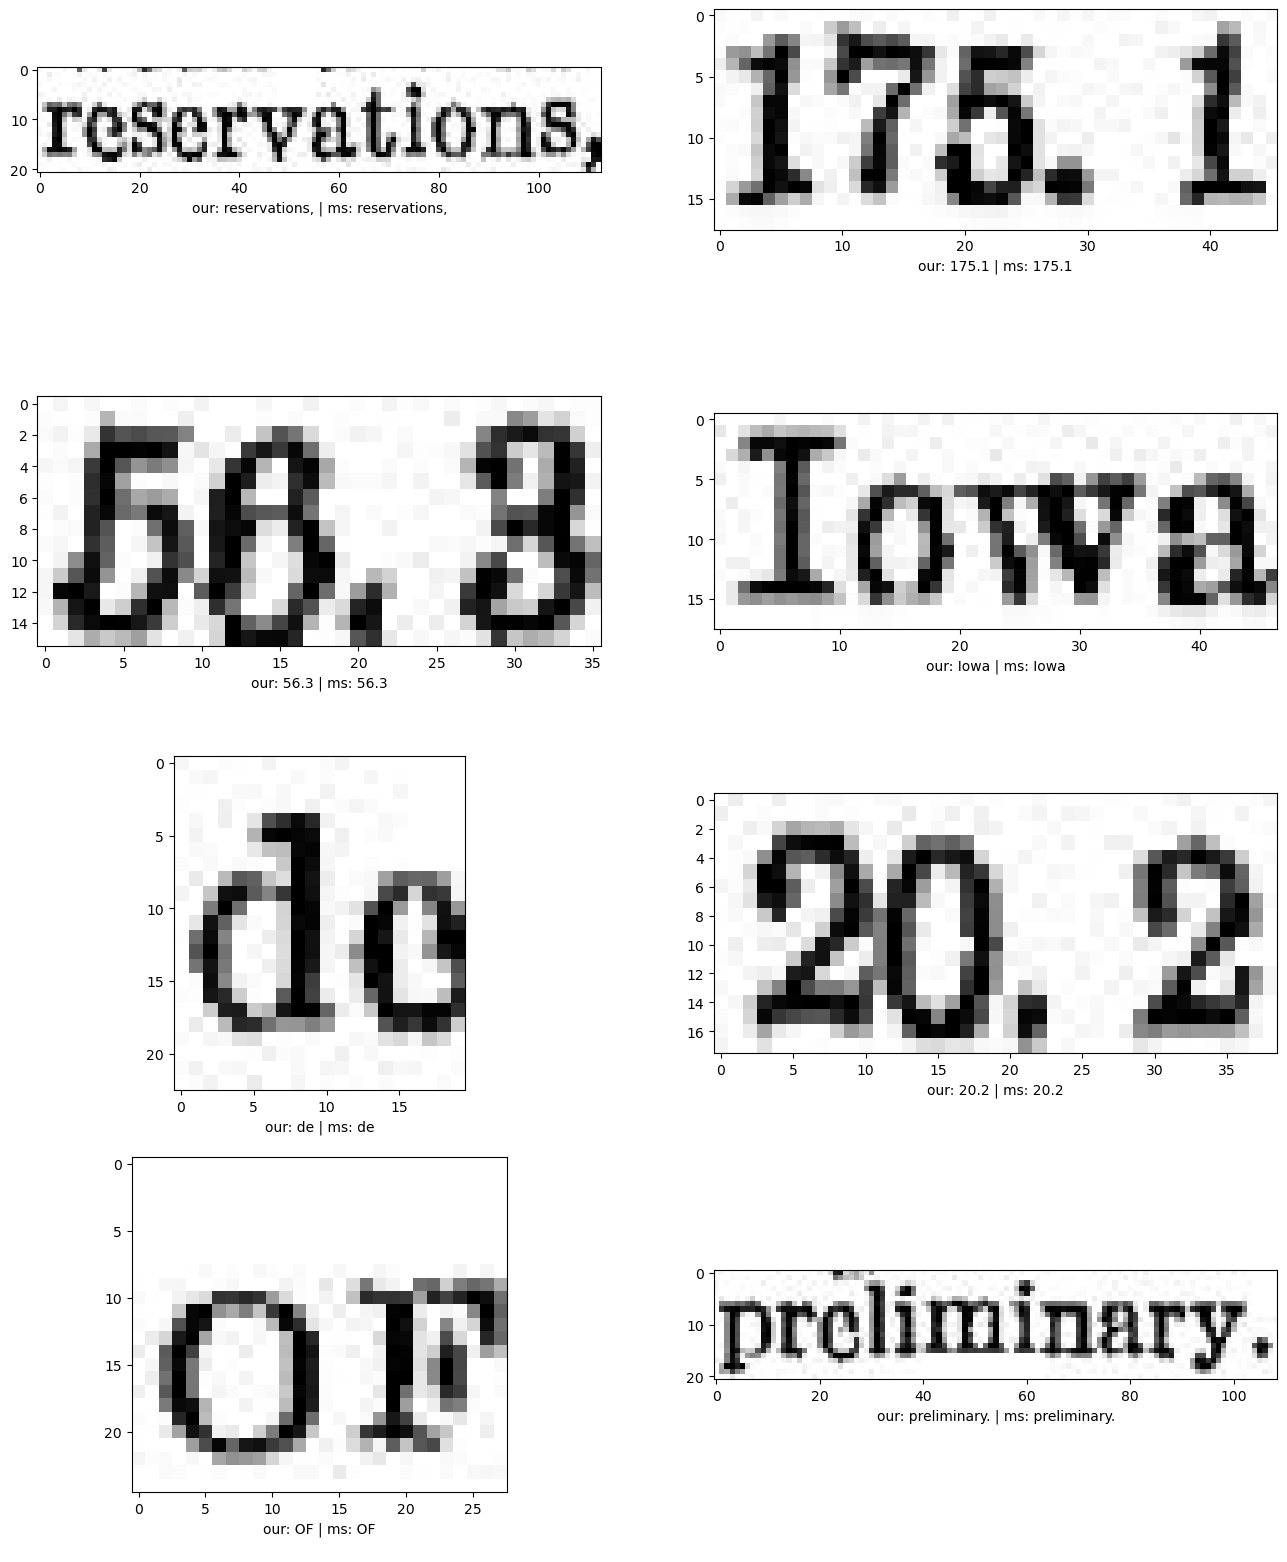

In [62]:
from PIL import Image
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()
files_to_observe = random.sample([c for c in combined], len(axes))
for fdict, ax in zip(files_to_observe, axes):
    path = os.path.join(ocr_reco_images_path, fdict['fname'])
    im = Image.open(path)
    ax.imshow(im)
    ax.set_xlabel(f"our: {fdict['gt']} | ms: {fdict['ms']}\n")

### Last but not least, end-to-end with MS

In [63]:
ms_result = ms_results[3]
ms_result['bboxes_absolute'].shape, ms_result['words'].shape

((776, 4), (776,))

In [64]:
gt_detection_for_val_page_ms = gt_detection_for_val_page.copy()
gt_detection_for_val_page_ms[:, 0] = gt_detection_for_val_page_ms[:, 0] + offsets[3][0]
gt_detection_for_val_page_ms[:, 2] = gt_detection_for_val_page_ms[:, 2] + offsets[3][0]
gt_detection_for_val_page_ms[:, 1] = gt_detection_for_val_page_ms[:, 1] + offsets[3][1]
gt_detection_for_val_page_ms[:, 3] = gt_detection_for_val_page_ms[:, 3] + offsets[3][1]

In [65]:
ms_metric = OCRMetric()
ms_metric.update(gt_detection_for_val_page_ms, 
                 ms_result['bboxes_absolute'],
                 gt_reco_for_val_page,
                 ms_result['words'])

print("MS end-to-end metrics:")
ms_metric.summary()

MS end-to-end metrics:


({'raw': 0.5584415584415584,
  'caseless': 0.5584415584415584,
  'anyascii': 0.5584415584415584,
  'unicase': 0.5584415584415584},
 {'raw': 0.38788659793814434,
  'caseless': 0.38788659793814434,
  'anyascii': 0.38788659793814434,
  'unicase': 0.38788659793814434},
 0.66)